# Image Data Explanation Benchmarking: Image Multiclass Classification

This notebook demonstrates how to use the benchmark utility to benchmark the performance of an explainer for image data. In this demo, we showcase explanation performance for partition explainer on an Image Multiclass Classification model. The metrics used to evaluate are "keep positive" and "keep negative". The masker used is Image Masker with Inpaint Telea.

The new benchmark utility uses the new API with MaskedModel as wrapper around user-imported model and evaluates masked values of inputs.

In [1]:
import json
import numpy as np
import shap
import shap.benchmark as benchmark
import tensorflow as tf
import scipy as sp
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

### Load Data and Model

In [2]:
model = ResNet50(weights='imagenet')
X, y = shap.datasets.imagenet50()

### Class Label Mapping

In [3]:
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

### Define Score Function

In [4]:
def f(x):
    tmp = x.copy()
    if len(tmp.shape) == 2: 
        tmp = tmp.reshape(tmp.shape[0], *X[0].shape)
    preprocess_input(tmp)
    return model(tmp)

### Define Image Masker

In [5]:
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

### Create Explainer Object

In [6]:
explainer = shap.Explainer(f, masker, output_names=class_names)

explainers.Partition is still in an alpha state, so use with caution...


### Run SHAP Explanation

In [7]:
shap_values = explainer(X[1:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]) 

Partition explainer:  50%|█████████████████                 | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [03:15, 65.24s/it]                                       


### Plot SHAP Explanation

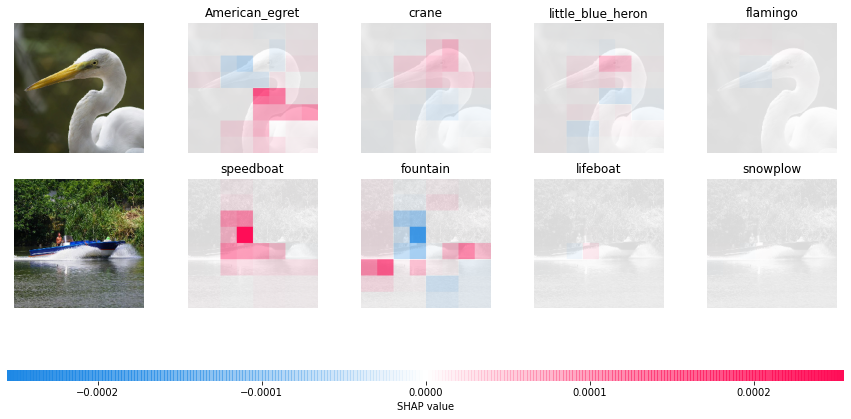

In [8]:
shap.image_plot(shap_values)

### Get Output Class Indices

In [9]:
output = f(X[1:3]).numpy()
num_of_outputs = 4
sorted_indexes = np.argsort(-output,axis=1)
sliced_indexes = np.array([index_list[:num_of_outputs] for index_list in sorted_indexes])

### Define Metrics (Sort Order & Perturbation Method)

In [10]:
sort_order = 'positive'
perturbation = 'keep'

### Benchmark Explainer

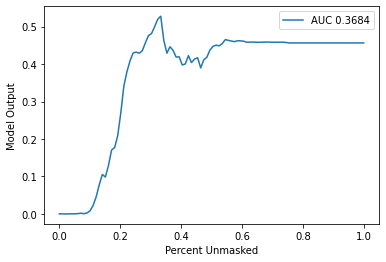

In [11]:
sequential_perturbation = benchmark.perturbation.SequentialPerturbation(explainer.model, explainer.masker, sort_order, perturbation)
xs, ys, auc = sequential_perturbation.model_score(shap_values, X[1:2], indices=sliced_indexes[0])
sequential_perturbation.plot(xs, ys, auc)